In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

In [ ]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict

from langgraph.prebuilt.chat_agent_executor import AgentState

  
def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}

class DeepAgentState(AgentState):
    """
    Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - files: Virtual file system stored as dict mapping filenames to content
    """
    
    # Incoming files will be append / update the current state
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

In [ ]:
from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

LS_DESCRIPTION = """
List all files in the virtual filesystem stored in agent state.

Shows what files currently exist in agent memory. Use this to orient yourself before other file operations and maintain awareness of your file organization.

No parameters required - simply call list_files() to see all available files.
"""



@tool(description=LS_DESCRIPTION)
def list_files(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
  """List all files in the virtual filesystem"""
  return list(state.get('files', {}).keys())

READ_FILE_DESCRIPTION = """
Read content from a file in the virtual filesystem with optional pagination.

This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks to avoid context overflow.

Parameters:
- file_path (required): Path to the file you want to read
- offset (optional, default=0): Line number to start reading from  
- limit (optional, default=2000): Maximum number of lines to read

Essential before making any edits to understand existing content. Always read a file before editing it.
"""
@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem (injected in tool node)
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """

    files = state.get('files', {})

    # directly check against the key
    if file_path not in files:
      return f"Error: File '{file_path}' not found"
    
    content = files[file_path]
    if not content:
      return "System reminder: File exists but has empty contents"
    
    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))
    
    if start_idx > end_idx:
      return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"
    
    result_lines = []
    for i in range(start_idx, end_idx):
      line_content = lines[i][:2000] # a max of 2000 characters will be extracted per line
      result_lines.append(f"{i + 1:6d}\t{line_content}")
    
    return '\n'.join(result_lines)

WRITE_FILE_DESCRIPTION = """
Create a new file or completely overwrite an existing file in the virtual filesystem.

This tool creates new files or replaces entire file contents. Use for initial file creation or complete rewrites. Files are stored persistently in agent state.

Parameters:
- file_path (required): Path where the file should be created/overwritten
- content (required): The complete content to write to the file

Important: This replaces the entire file content.
"""

@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem (injected in tool node)
        tool_call_id: Tool call identifier for message response (injected in tool node)

    Returns:
        Command to update agent state with new file content
    """
    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )
    
    # Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result

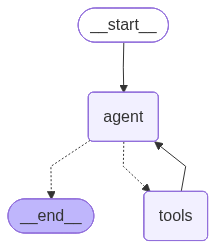

In [13]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from utils import format_messages

# Create agent using create_react_agent directly
model = init_chat_model(model="openai:gpt-4.1-mini", temperature=0.0)
tools = [list_files, read_file, write_file, web_search]

FILE_USAGE_INSTRUCTIONS = """You have access to a virtual file system to help you retain and save context.

## Workflow Process - EXECUTE EVERY STEP IN ORDER

1. **Orient**: Use list_files() to see what files exist

2. **Save the user's request**: Use write_file() to save the current request/question
   - Do this regardless of whether files exist
   - This ensures context is preserved for future interactions

3. **Check for relevant files**: If files exist that might contain relevant information:
   - Read them using read_file()
   - Use the information to help answer the question

4. **Conduct research**: Use web_search to find information needed to answer the question

5. **Answer the user**: Provide a complete answer combining:
   - Information from any existing files you read
   - Information from your web search
   - Always directly answer the user's original question"""

# Research instructions
RESEARCH_INSTRUCTIONS = """When answering the user's question, you MUST:
1. List files with list_files()
2. Write the user's request to a file with write_file()
3. Read any existing relevant files with read_file()
4. Perform web_search to gather information
5. Provide a complete answer to the user's question using all gathered information"""

# Full prompt with proper ordering
INSTRUCTIONS = (
    FILE_USAGE_INSTRUCTIONS + "\n\n" + "=" * 80 + "\n\n" + RESEARCH_INSTRUCTIONS
)

# Create agent with system prompt
agent = create_react_agent(
    model, tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [14]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
        "files": {},
    }
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: list_files                                                                                        │
│    Args: {}                                                                                                     │
│    ID: call_afGuBZP5lLYiPBOWGcMGj29S                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.txt",                                                                              │
│   "content": "Give me an overview of Model Context Protocol (MCP)."                                             │
│ }                                                                                                               │
│    ID: call_n0wScONxttyLLGRWtlYoJ5se                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.txt                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview"                                                                │
│ }                                                                                                               │
│    ID: call_J2dBgDjynUPA6hrZ07jWVBMX                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed                                         │
│ by Anthropic to enable seamless integration between AI models and external systems like                         │
│ tools, databases, and other services. It acts as a standardized communication layer,                            │
│ allowing AI models to access and utilize data from various sources in a consistent and                          │
│ efficient manner. Essentially, MCP simplifies the process of connecting AI assistants                           │
│ to external services by providing a unified language for data exchange.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed by Anthropic. It is designed to enable  │
│ seamless integration between AI models and external systems such as tools, databases, and other services. MCP   │
│ acts as a standardized communication layer that allows AI models to access and utilize data from various        │
│ sources in a consistent and efficient manner. The main purpose of MCP is to simplify the process of connecting  │
│ AI assistants to external services by providing a unified language for data exchange. This helps in enhancing   │
│ the capabilities of AI models by allowing them to interact with and leverage external information and           │
│ functionalities.                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯